In [1]:
##### nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build

# !pip install snowflake --user
# !pip install snowflake-connector-python --userqr4
# !pip install category_encoders
# !pip install xgboost
# !pip install fuzzywuzzy --user
# !pip install lightgbm --user

import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


## Functions

In [2]:

def _encode(df, categoricals):
    """
    perform category encoding on the data
    :param df: dataframe to be encoded
    :param categoricals: list of name of categorical columns
    :return ohe, x_ohe: OHE object and OHE-encoded data
    """

    ohe = OneHotEncoder(cols=categoricals, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',  
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df)
    return ohe, x_ohe


def train_lr(df_train, features_cat, features_cont, target):
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
  
    # fit
    lm = LinearRegression()
    model = lm.fit(x_ohe, y_train)
       
    return model, ohe

def predict_lr(df_test, model, ohe, features_cat, features_cont, target, postfix):    
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    y_pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
  
    rmse = np.sqrt(MSE(np.exp(y_test), np.exp(pred)))
    mae = MAE(np.exp(y_test), np.exp(pred))
    print("Aggergate error : % f" %(np.exp(pred).sum()-np.exp(y_test).sum()))
    print("RMSE : % f" %(rmse))
    print("MAE : % f" %(mae)) 
    
    return df_pred

def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test, label=y_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[list(set(['title_name', 'title_id','category','season_number', 'effective_start_date'] + features_cat + features_cont + ['first_views']))]
    df_pred['first_views_log_{}'.format(postfix)] = pred

    return df_pred



def train_lgbm(df_train, features_cat, features_cont, target, param):       
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)

    x_train = lightgbm.Dataset(x_ohe, label=y_train)
    model = lightgbm.train(param, x_train, verbose_eval = -1)

    return model, ohe


def predict_lgbm(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_log_{}'.format(postfix)] = pred
    df_pred.head()

    return df_pred


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')



## Features 

target = 'first_views_log'

features_cat=[
    'start_year',
#     'start_quarter',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot'
]


### Model parameters 
param_xgb = {"booster":"gbtree",
             "objective":"reg:squarederror",
            "gamma":1}


param_lgbm = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



# Prediction

#### Get train/pred data

In [3]:
date_eval_end = '2021-09-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_1025.csv')
df_raw= df_raw.copy()
df_raw['effective_start_date'] = pd.to_datetime(df_raw['effective_start_date'])
df_raw['start_year'] = pd.to_datetime(df_raw['effective_start_date']).dt.year
df_raw['start_month'] = pd.to_datetime(df_raw['effective_start_date']).dt.month
df_raw['start_year_month'] = df_raw['effective_start_date'].dt.strftime('%Y-%m')
df_raw['start_quarter'] = df_raw['effective_start_date'].dt.quarter

df_raw = df_raw[(df_raw['effective_start_date']<=date_eval_end) & (df_raw.title_name!='Dune')]

grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date', 'start_year', 'start_month', 'start_year_month', 'start_quarter']
df = df_raw[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
print(df.shape)
print('# title: ', df.title_name.nunique())
df = df[df['first_views']!=0]
print(df.shape)
df['first_views_log'] = np.log(df['first_views'])


## add imdb features 
df_imdb = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered.csv')
print(df_imdb.columns)

col = ['title_id', 'asset_title_long', 'imdb_id', 'genres', 'title_type',
       'ref_follows', 'ref_remake_of', 'ref_spin_off_from', 'ref_version_of',
      'ref_ref_featured_in','ref_ref_spoofed_in']
df = df.merge(df_imdb[col], how='left', on=['title_id'])
df['ref_tot'] = df[['ref_follows','ref_remake_of','ref_spin_off_from','ref_version_of']].sum(axis=1)
df['ref_ref_tot'] = df[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)

## Clean data and make a copy for evaluation
df = df.fillna(0)
df.head(2)
print(df.shape)
print('# title: ', df.title_name.nunique())
print(df.columns)
df=df.drop_duplicates(subset=['title_id','tier','category','season_number'],keep='first')
print(df.shape)

df_actual = df.copy()

## Adjust tier feature for train & pred 
df.loc[(df['category']=='Popcorn') & (df['tier']==1), ['tier']] = 0
df.loc[(df['category']=='Popcorn') & (df['tier']==2), ['tier']] = 1

df_train = df.copy()

(317, 14)
# title:  268
(317, 14)
Index(['Unnamed: 0', 'tier', 'content_category', 'category', 'title_name',
       'title_id', 'season_number', 'program_type', 'first_views',
       'title_type', 'imdb_id', 'asset_title_long', 'genres', 'ref_follows',
       'ref_spin_off_from', 'ref_remake_of', 'ref_version_of',
       'ref_ref_featured_in', 'ref_ref_spoofed_in'],
      dtype='object')
(623, 27)
# title:  268
Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'program_type', 'effective_start_date', 'start_year',
       'start_month', 'start_year_month', 'start_quarter', 'first_views',
       'premiering_hours_runtime', 'first_views_log', 'asset_title_long',
       'imdb_id', 'genres', 'title_type', 'ref_follows', 'ref_remake_of',
       'ref_spin_off_from', 'ref_version_of', 'ref_ref_featured_in',
       'ref_ref_spoofed_in', 'ref_tot', 'ref_ref_tot'],
      dtype='object')
(317, 27)


#### Train & predict

In [4]:
date_eval_end = '2021-09-01'
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']

## Get decay curve 
def get_decay_data_title(df_plt, grpby):
    df_plt = df_plt[grpby + ['days_since_premiere','first_views']].sort_values(by=grpby+['days_since_premiere'])
    df_plt['first_views_sum'] = df_plt.groupby(grpby)['first_views'].transform('sum')
    df_plt['first_views_cumsum'] = df_plt.groupby(by=grpby)['first_views'].cumsum()
    df_plt['first_views_cumpct'] = df_plt['first_views_cumsum'] / df_plt['first_views_sum']
    df_plt.reset_index(inplace=True)
    return df_plt

def get_decay_data(df_plt, grpby):
    df_plt = df_plt[grpby + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=grpby+['days_since_premiere'])
    df_plt = df_plt.groupby(by=grpby + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
    df_plt['first_views_pct'] = df_plt.groupby(grpby)['first_views_cumpct'].diff()
    df_plt = df_plt.rename(columns={'title_id':'title_count_training'})
    df_plt.reset_index(inplace=True)
    df_plt.loc[(df_plt['first_views_pct'].isnull()) & (df_plt.days_since_premiere==0),'first_views_pct'] = df_plt['first_views_cumpct']
    df_plt['days_since_premiere'] = df_plt['days_since_premiere'].astype(int)
    return df_plt


In [5]:
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev_b'
offset = 3

var_agg = 'first_view_month'
date_eval_end = '2021-09-01'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
# list_date_pred = ['2021-02-01',]
for date_pred in list_date_pred:
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date >= datetime.strptime(date_pred, '%Y-%m-%d')]
#     df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))
    df_pred['tier_original'] = df_pred['tier']
    df_pred.loc[(df['category']=='Popcorn') & (df['tier']==0), ['tier_original']] = 1
    df_pred.loc[(df['category']=='Popcorn') & (df['tier']==1), ['tier_original']] = 2
    df_pred['pred_date'] = date_pred
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_data(df_decay_title, ['category'])
    df_decay_tier = get_decay_data(df_decay_title, ['tier'])
    df_decay_tier['tier_original'] = df_decay_tier['tier']
    df_pred_decay = df_pred.merge(df_decay_tier[['tier_original','days_since_premiere','first_views_pct']], 
                                                on=['tier_original'],
                                                  how='left', suffixes=['', '_tier_o'])\
                            .merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                                                on=['category','days_since_premiere'], how='left', suffixes=['','_category'])\
                            .merge(df_decay_tier[['tier','days_since_premiere','first_views_pct']], 
                                            on=['tier','days_since_premiere'], how='left', suffixes=['', '_tier'])

    df_pred_decay['first_views_pct_tier_original']  = df_pred_decay['first_views_pct'] 
    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct_category']
    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct'].fillna(df_pred_decay['first_views_pct_tier'])
    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct'].fillna(df_pred_decay['first_views_pct_tier_original'])
    df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
    df_pred_decay[f'first_views_decay_{postfix}'] = df_pred_decay[f'first_views_{postfix}'] * df_pred_decay['first_views_pct']
    df_pred_decay[df_pred_decay.category=='Popcorn']
    df_pred_list.append(df_pred_decay)  
    
df_pred_decay = pd.concat(df_pred_list)
display(df_pred_decay[df_pred_decay.category=='Popcorn'])

2021-01-01 86 (0, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-02-01 105 (0, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-03-01 122 (1, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-04-01 135 (2, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-05-01 146 (4, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-06-01 158 (5, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-07-01 168 (6, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-08-01 177 (7, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,tier,category,ref_tot,title_name,effective_start_date,start_year,season_number,first_views,program_type,title_id,content_category,first_views_log_dev_b,first_views_dev_b,tier_original,pred_date,days_since_premiere,first_views_pct,first_views_pct_category,first_views_pct_tier,first_views_pct_tier_original,request_date,first_views_decay_dev_b
273,0,Popcorn,5.0,Godzilla vs. Kong,2021-03-31,2021,0,2017166,acquired,GYFEzmwNES16GkQEAAAAC,movies,237.106033,7420.774902,1,2021-01-01,0,0.041857,NaN,NaN,0.041857,2021-03-31,310.613541
274,0,Popcorn,5.0,Godzilla vs. Kong,2021-03-31,2021,0,2017166,acquired,GYFEzmwNES16GkQEAAAAC,movies,237.106033,7420.774902,1,2021-01-01,1,0.057669,NaN,NaN,0.057669,2021-04-01,427.949817
275,0,Popcorn,5.0,Godzilla vs. Kong,2021-03-31,2021,0,2017166,acquired,GYFEzmwNES16GkQEAAAAC,movies,237.106033,7420.774902,1,2021-01-01,2,0.048636,NaN,NaN,0.048636,2021-04-02,360.920215
276,0,Popcorn,5.0,Godzilla vs. Kong,2021-03-31,2021,0,2017166,acquired,GYFEzmwNES16GkQEAAAAC,movies,237.106033,7420.774902,1,2021-01-01,3,0.080221,NaN,NaN,0.080221,2021-04-03,595.304250
277,0,Popcorn,5.0,Godzilla vs. Kong,2021-03-31,2021,0,2017166,acquired,GYFEzmwNES16GkQEAAAAC,movies,237.106033,7420.774902,1,2021-01-01,4,0.046471,NaN,NaN,0.046471,2021-04-04,344.848640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1,Popcorn,0.0,Reminiscence,2021-08-20,2021,0,68705,acquired,GYQBEaQwta8PCAAEAAAA-,movies,578.679688,339186.812500,2,2021-08-01,86,0.001354,NaN,0.001354,0.002693,2021-11-14,459.413609
360,1,Popcorn,0.0,Reminiscence,2021-08-20,2021,0,68705,acquired,GYQBEaQwta8PCAAEAAAA-,movies,578.679688,339186.812500,2,2021-08-01,87,0.001492,NaN,0.001492,0.002682,2021-11-15,505.936507
361,1,Popcorn,0.0,Reminiscence,2021-08-20,2021,0,68705,acquired,GYQBEaQwta8PCAAEAAAA-,movies,578.679688,339186.812500,2,2021-08-01,88,0.001812,NaN,0.001812,0.001898,2021-11-16,614.478655
362,1,Popcorn,0.0,Reminiscence,2021-08-20,2021,0,68705,acquired,GYQBEaQwta8PCAAEAAAA-,movies,578.679688,339186.812500,2,2021-08-01,89,0.001968,NaN,0.001968,0.002363,2021-11-17,667.632716


## Evaluation

In [6]:

def get_agg_first_views(df_in, grpby_title, agg_col, first_view_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()

    return df_in

def get_plot(dflist, varlist, labellist=None,  ## Old
              title=None, config={}, x_var='order_date', y_var='y_var',  mode='lines+markers'):
    ## Create dataframe x var combinations (plot all variables for each dataframe)
    dfvarlist=itertools.product(*[dflist,varlist])
        
    ## For every dataframe x variable, create a data trace for plotting
    data=[]    
    for dfvar, name in zip(dfvarlist, labellist):
        dfplt,var=dfvar[0], dfvar[1]
        data = data + [go.Scatter(x=dfplt[x_var], y=dfplt[var], mode=mode, name=name)]  

    ## Initiate offline plot and create plot
    py.offline.init_notebook_mode(connected=True) 
    layout = dict(title = title,
                  xaxis = dict(title = x_var), #, range=['2017-09-01','2017-02-01']
                  yaxis = dict(title = y_var),
                  autosize=False,
                  width=(600),
                  height=(400),
                  showlegend=True,
                 )
    fig = dict(data=data, layout=layout)
    return fig

def evaluate_pred_group(df_plt, grpby, key, pred_list):

    for quarter, group in df_plt.groupby(grpby):
        actuals_mean=group['first_views'].mean()
        actuals_sum=group['first_views'].sum()
        print('_____________________________________________________________')
        print(f'{key} {quarter} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
        for i in ['median_mx'] + list_postfix:  
            mae = MAE(group['first_views'], group[f'first_views_decay_{i}'])
            pred= group[f'first_views_decay_{i}'].sum()
            print(f'{key} {quarter} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')
    
    return

def evaluate_pred_plt(df_plt, grpby, var_list):
    mean_var_list = [f'mae_{i}' for i in var_list]
    sum_var_list = ['first_views'] + var_list 
    mean_dic = dict(zip(mean_var_list, ['mean'] * len(mean_var_list)))
    sum_dic = dict(zip(sum_var_list, ['sum'] * len(sum_var_list)))
    
    # Get absolute error at agg_time- title level
    df_grp = df_plt.groupby(by=grpby).agg(sum_dic).reset_index()
    for i in var_list:
        df_grp[f'mae_{i}'] = (df_grp[i] - df_grp['first_views']).abs()  ## mae is actually ae here. mean taken in the next step

    ## aggregate to agg_time level (month, quarter)
    agg_dic =  {k: v for d in (mean_dic, sum_dic) for k, v in d.items()}
    df_grp = df_grp.groupby(by=grpby[:-2]).agg(agg_dic).reset_index()
    for i in var_list:
        df_grp[f'pct_error_{i}'] = (df_grp[i] - df_grp['first_views'])/df_grp['first_views']*100

    return df_grp

def get_pred_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'first_views_decay_{i}' for i in ['median_mx', 'dev_b']] + ['first_views'] ## Variables to be plotted
            ,'title': title  ## Plot title
            ,'labellist':['Median','XGB', 'Actual'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': 'First views'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    py.offline.iplot(fig)
    
    return 

def get_pct_error_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'pct_error_first_views_decay_{i}' for i in ['median_mx', 'dev_b']] ## Variables to be plotted
            ,'title':title  ## Plot title
            ,'labellist':['Median','XGB'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': '% error (Quarter aggregate)'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    fig['layout']['yaxis'].update({'ticksuffix':'%'})
    py.offline.iplot(fig)
    
    return 



In [149]:
def get_filtered_first_views(df_in, offset, grpby_title, first_view_date_col, first_view_col, postfix):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting contents three months out? 
    ##      Make predictions in Feb 2021 for May 2021 and evaluate  
    ## => 3 months offset, pred_date = 2021-02-01, first_view_month = 2021-05-01  
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
#     df_in['offset_month'] = df_in['pred_date'] + pd.DateOffset(months=offset)

    ## select rows where pred_date > premiere_date, and seq_date month = offset_month 
    df_in = df_in[(df_in['pred_date']== df_in['first_view_month'] - pd.DateOffset(months=offset))]  
    return df_in
    
def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in


# agg_var = 'first_view_month'
# offset = 3

# grpby_title= ['title_name', 'title_id', 'season_number', 'effective_start_date', 'tier','content_category','category']
# df_eval_actuals = df_raw[(df_raw.effective_start_date>='2021-01-01') & (df_raw.effective_start_date<'2021-09-01')].copy()
# df_eval_actuals = get_agg_first_views(df_eval_actuals, agg_var, grpby_title, 'request_date', 'first_views', 'actual')

# display(df_eval_actuals[df_eval_actuals.title_name.str.contains('Mortal')])
# display(df_eval_actuals[df_eval_actuals.title_name.str.contains('Mortal')].first_views.sum())

# #### Get xgb prediction 
# postfix = 'dev_b'
# grpby_title= ['title_name', 'season_number']
# df_pred_dev_b = get_filtered_first_views(df_pred_decay, offset, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)
# # df_pred_dev_b = get_agg_first_views(df_pred_dev_b, agg_var, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)
# display(df_pred_dev_b[df_pred_dev_b.first_view_month=='2021-05-01'].pred_date.unique())
# display(df_pred_dev_b[df_pred_dev_b.title_name.str.contains('Mortal')].first_views_dev_b.unique())
# # display(df_pred_dev_b[df_pred_dev_b.title_name.str.contains('Mortal')])

df_median_mx = get_filtered_first_views(df_median_mx_raw, offset, grpby_title, 'seq_date', 'predicted_first_views', postfix)
display(df_median_mx[df_median_mx.first_view_month=='2021-05-01'].pred_date.unique())
display(df_median_mx[df_median_mx.title_name.str.contains('Friends')].predicted_first_views.unique())
# display(df_pred_dev_b[df_pred_dev_b.title_name.str.contains('Mortal')])



array(['2021-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

array([8.493e+03, 7.964e+03, 6.407e+03, 5.455e+03, 3.643e+03, 2.753e+03,
       2.775e+03, 2.321e+03, 1.765e+03, 1.603e+03, 1.573e+03, 1.084e+03,
       9.750e+02, 1.136e+03, 1.038e+03, 8.840e+02, 8.640e+02, 7.390e+02,
       5.840e+02, 5.890e+02, 5.190e+02, 5.590e+02, 5.560e+02, 5.500e+02,
       4.920e+02, 3.950e+02, 3.320e+02, 3.700e+02, 3.660e+02, 2.300e+02,
       3.000e+02, 2.770e+02, 2.310e+02, 2.020e+02, 2.690e+02, 1.960e+02,
       1.770e+02, 1.540e+02, 1.790e+02, 1.490e+02, 1.280e+02, 1.700e+02,
       1.360e+02, 1.240e+02, 1.860e+02, 8.500e+01, 1.400e+02, 8.300e+01,
       9.900e+01, 2.720e+02, 2.010e+02, 2.500e+02, 2.880e+02, 2.170e+02,
       2.540e+02, 2.090e+02, 1.990e+02, 2.240e+02, 1.270e+02, 1.850e+02,
       9.800e+01, 1.420e+02, 5.200e+01, 1.120e+02, 6.900e+01, 6.700e+01,
       5.600e+01, 1.290e+02, 1.310e+02, 3.800e+01, 7.700e+01, 8.400e+01,
       3.400e+01, 3.200e+01, 1.050e+02, 3.900e+01, 7.200e+01, 5.700e+01,
       2.900e+01, 2.000e+01, 7.500e+01, 8.900e+01, 

In [201]:
df_median_mx_raw = []
for date, date_start in zip(['0101','0201','0301','0401','0501', '0601', '0701', '0801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['pred_date'] = date_start
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
#     df_temp = df_temp[df_temp['premiere_date'] >= df_temp['pred_date']]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)
df_median_mx_raw['first_view_month'] = pd.to_datetime(df_median_mx_raw['seq_date']).dt.to_period('M').dt.to_timestamp()

df_a = df_median_mx_raw[(df_median_mx_raw.pred_date=='2021-04-01')]
display(df_a[['first_view_month', 'predicted_first_views']].groupby(by='first_view_month').sum().head(5))



df_a = df_median_mx_raw[(df_median_mx_raw.pred_date=='2021-05-01')]
display(df_a[['first_view_month', 'predicted_first_views']].groupby(by='first_view_month').sum().head(5))
# df_median_mx_raw[(df_median_mx_raw.title_name.str.contains('Those'))
#                 & (df_median_mx_raw.category=='Popcorn')][['pred_date','first_view_month','seq_date','predicted_first_views']].groupby(by='pred_date').sum()



,predicted_first_views
first_view_month,
2021-03-01,391498.0
2021-04-01,4644877.0
2021-05-01,1007438.0
2021-06-01,142678.0
2021-07-01,34676.0


,predicted_first_views
first_view_month,
2021-04-01,3794.0
2021-05-01,734699.0
2021-06-01,429692.0
2021-07-01,93316.0
2021-08-01,37852.0


In [203]:
df_median_mx_raw = []
for date, date_start in zip(['210401'], 
                            ['2021-04-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['pred_date'] = date_start
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
#     df_temp = df_temp[df_temp['premiere_date'] >= df_temp['pred_date']]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)
df_median_mx_raw['first_view_month'] = pd.to_datetime(df_median_mx_raw['seq_date']).dt.to_period('M').dt.to_timestamp()

df_a = df_median_mx_raw[(df_median_mx_raw.pred_date=='2021-04-01')]
display(df_a[['first_view_month', 'predicted_first_views']].groupby(by='first_view_month').sum().head(7))



df_a = df_median_mx_raw[(df_median_mx_raw.pred_date=='2021-05-01')]
display(df_a[['first_view_month', 'predicted_first_views']].groupby(by='first_view_month').sum().head(7))
# df_median_mx_raw[(df_median_mx_raw.title_name.str.contains('Those'))
#                 & (df_median_mx_raw.category=='Popcorn')][['pred_date','first_view_month','seq_date','predicted_first_views']].groupby(by='pred_date').sum()



,predicted_first_views
first_view_month,
2021-03-01,26294.0
2021-04-01,341121.0
2021-05-01,368412.0
2021-06-01,342892.0
2021-07-01,365298.0
2021-08-01,428794.0
2021-09-01,297148.0


,predicted_first_views
first_view_month,


In [200]:
df_median_mx_raw = []
for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['pred_date'] = date_start
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
#     df_temp = df_temp[df_temp['premiere_date'] >= df_temp['pred_date']]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)
df_median_mx_raw['first_view_month'] = pd.to_datetime(df_median_mx_raw['seq_date']).dt.to_period('M').dt.to_timestamp()

df_a = df_median_mx_raw[(df_median_mx_raw.pred_date=='2021-04-01')]
display(df_a[['first_view_month', 'predicted_first_views']].groupby(by='first_view_month').sum().head(7))



df_a = df_median_mx_raw[(df_median_mx_raw.pred_date=='2021-05-01')]
display(df_a[['first_view_month', 'predicted_first_views']].groupby(by='first_view_month').sum().head(7))
# df_median_mx_raw[(df_median_mx_raw.title_name.str.contains('Those'))
#                 & (df_median_mx_raw.category=='Popcorn')][['pred_date','first_view_month','seq_date','predicted_first_views']].groupby(by='pred_date').sum()



,predicted_first_views
first_view_month,
2021-03-01,26294.0
2021-04-01,341121.0
2021-05-01,368412.0
2021-06-01,342892.0
2021-07-01,365298.0
2021-08-01,428794.0
2021-09-01,297148.0


,predicted_first_views
first_view_month,
2021-04-01,2702.0
2021-05-01,165552.0
2021-06-01,315590.0
2021-07-01,592057.0
2021-08-01,772167.0
2021-09-01,324734.0
2021-10-01,707383.0


In [175]:
df_eval[df_eval.first_view_month=='2021-05-01'][[,'first_views','first_views_decay_median_mx','first_views_decay_dev_b']].sum()



title_name                         A Black Lady Sketch ShowA Tiny AudienceAllen v...
title_id                           GXRt2ogky7r29bAEAAAGeGXcsTHA88FJuAuwEAAASxGYB3...
season_number                                                                     62
tier                                                                             148
content_category                   seriesseriesseriesseriesseriesmoviesseriesmovi...
category                           Scripted Comedy SeriesInternationalDocu-Series...
first_views                                                                  1276706
predicted_first_views                                                         333240
first_views_decay_median_mx                                                   333240
title_name_match                   A Black Lady Sketch ShowA Tiny AudienceAllen v...
title_name_fp                      A Black Lady Sketch ShowHBO Latino Presents: A...
first_views_decay_dev_b                                          

In [153]:
df_eval[df_eval.first_view_month=='2021-05-01'][['title_name','premiere_date','first_views','first_views_decay_median_mx','first_views_decay_dev_b']].sort_values(by='first_views', ascending=Fal

,title_name,premiere_date,first_views,first_views_decay_median_mx,first_views_decay_dev_b
76,Friends: The Reunion,2021-05-27,553123,31962.0,147430.478321
189,Mortal Kombat,2021-04-23,309295,52956.0,3508.704273
340,Those Who Wish Me Dead,2021-05-14,120558,255.0,230476.637211
181,Mare of Easttown,2021-04-18,76782,72222.0,158008.448728
369,Zack Snyder's Justice League,2021-03-18,45316,15309.0,53113.761131
253,Tenet,2021-05-15,24844,0.0,242891.710339
313,The Nevers,2021-04-11,23077,64588.0,155768.334031
106,Greenland,2021-05-15,21963,6065.0,19429.683990
110,Hacks,2021-05-13,17131,785.0,35530.382692
96,Godzilla vs. Kong,2021-03-31,10594,928.0,1432.787186


In [34]:
def get_filtered_first_views(df_in, offset, grpby_title, first_view_date_col, first_view_col, postfix):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting contents three months out? 
    ##      Make predictions in Feb 2021 for May 2021 and evaluate  
    ## => 3 months offset, pred_date = 2021-02-01, first_view_month = 2021-05-01  
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
#     df_in['offset_month'] = df_in['pred_date'] + pd.DateOffset(months=offset)

    ## select rows where pred_date > premiere_date, and seq_date month = offset_month 
    df_in = df_in[(df_in['pred_date']== df_in['first_view_month'] - pd.DateOffset(months=offset))]  
    return df_in
    
def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in


agg_var = 'first_view_month'
offset = 0

#### Get actuals
grpby_title= ['title_name', 'title_id', 'season_number', 'effective_start_date', 'tier','content_category','category']
df_eval_actuals = df_raw[(df_raw.effective_start_date>='2021-01-01') & (df_raw.effective_start_date<'2021-09-01')].copy()
df_eval_actuals = get_agg_first_views(df_eval_actuals, agg_var, grpby_title, 'request_date', 'first_views', 'actual')


#### Get xgb prediction 
postfix = 'dev_b'
grpby_title= ['title_name', 'season_number']
df_pred_dev_b = get_filtered_first_views(df_pred_decay, offset, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)
df_pred_dev_b = get_agg_first_views(df_pred_dev_b, agg_var, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)


##### Get baseline prediction

## Get raw data 
df_median_mx_raw = []
for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['pred_date'] = date_start
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
    df_temp = df_temp[df_temp['premiere_date'] >= df_temp['pred_date']]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)


##. Get prediction according to offset period 
## e.g. How good are we in predicting contents three months out? 
##      Make predictions in Feb 2021 for May 2021 and evaluate  
## => 3 months offset, pred_date = 2021-02-01, first_view_month = 2021-05-01  
grpby_title= ['title_name', 'season_number', 'premiere_date', 'pred_date']
postfix = 'median_mx'

##  Get predictions
df_median_mx = get_filtered_first_views(df_median_mx_raw, offset, grpby_title, 'seq_date', 'predicted_first_views', postfix)
df_median_mx = get_agg_first_views(df_median_mx, agg_var, grpby_title, 'seq_date', 'predicted_first_views', postfix)
df_median_mx['first_views_decay_median_mx'] = df_median_mx['predicted_first_views'] 

# ## Match title name to titles in actuals 
# df_title = df_median_mx_raw[grpby_title].drop_duplicates(subset=['title_name'])
# df_title['title_name_match'] = df_title['title_name'].apply(lambda x: process.extractOne(x, list(df_eval_actuals['title_name'].unique()), score_cutoff=90))
# name_from_df2_list = df_title['title_name_match'].to_list()
# name_from_df2_list = [_[0] if _ != None else None for _ in name_from_df2_list]
# df_title['title_name_match'] = name_from_df2_list
# df_title.loc[df_title.title_name=='Euphoria Special Episode Part Two', 'title_name_match'] = 'Euphoria Special Episode Part 2: Jules'
# df_title.loc[df_title.title_name.str.contains('Juan Luis'), 'title_name_match'] = 'Juan Luis Guerra 4.40: Entre Mar y Palmeras'

## Merge titles and seasons 
df_median_mx = df_median_mx.merge(df_title[['title_name','title_name_match']], how='left', on=['title_name'])
df_median_mx['title_name_fp'] = df_median_mx['title_name']
df_median_mx['title_name'] = df_median_mx['title_name_match']

# Fill in seasons 
df_title_season = df_eval_actuals.drop_duplicates(subset=['title_name','season_number'])
df_median_mx_season = df_median_mx[df_median_mx.season_number!=0]
df_median_mx_noseason = df_median_mx[df_median_mx.season_number==0]
df_median_mx_noseason = df_median_mx_noseason.merge(df_title_season[['title_name','season_number']], on=['title_name'])
df_median_mx_noseason['season_number'] = df_median_mx_noseason['season_number_y'] 
df_median_mx = pd.concat([df_median_mx_season,df_median_mx_noseason[df_median_mx_season.columns]])
print(df_median_mx.shape)
df_median_mx = df_median_mx.drop_duplicates(subset=['title_name','season_number', agg_var])
print(df_median_mx.shape)

## Merge actual, median baseline and prediction 
display(df_eval_actuals.head(2))
display(df_median_mx.head(2))
display(df_pred_dev_b.head(2))
df_eval = df_eval_actuals.merge(df_median_mx, on=['title_name', 'season_number', agg_var], how='inner')\
        .merge(df_pred_dev_b[['title_name','season_number',agg_var,'first_views_decay_dev_b']], on=['title_name','season_number',agg_var], how='left')
print(df_eval.title_name.nunique())
print(df_eval.isnull().sum())
print(df_eval[df_eval.title_name_match.isnull()].title_name.nunique())
print(df_eval[df_eval.first_views_decay_dev_b.isnull()].title_name.nunique())
print(df_eval.columns)
df_eval = df_eval.dropna()
df_eval = df_eval[df_eval.title_name!='Tenet']

df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_decay_median_mx_log'] = np.log(df_eval['first_views_decay_median_mx'])
df_eval['first_views_decay_dev_b_log'] = np.log(df_eval['first_views_decay_dev_b'])


# df_eval_ = df_eval.copy()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(133, 9)
(133, 9)


,title_name,title_id,season_number,effective_start_date,tier,content_category,category,first_view_month,first_views
0,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-07-01,5917
1,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,2021-08-01,8994


,title_name,season_number,premiere_date,pred_date,first_view_month,predicted_first_views,first_views_decay_median_mx,title_name_match,title_name_fp
0,100 Foot Wave,1,2021-07-18,2021-07-01,2021-07-01,4220.0,4220.0,100 Foot Wave,100 Foot Wave
2,A Black Lady Sketch Show,2,2021-04-23,2021-04-01,2021-04-01,317.0,317.0,A Black Lady Sketch Show,A Black Lady Sketch Show


,title_name,season_number,first_view_month,first_views_decay_dev_b
0,100 Foot Wave,1,2021-07-01,2633.320176
1,30 Coins (30 Monedas),1,2021-01-01,825.825853


120
title_name                     0
title_id                       0
season_number                  0
effective_start_date           0
tier                           0
content_category               0
category                       0
first_view_month               0
first_views                    0
premiere_date                  0
pred_date                      0
predicted_first_views          0
first_views_decay_median_mx    0
title_name_match               0
title_name_fp                  0
first_views_decay_dev_b        1
dtype: int64
0
1
Index(['title_name', 'title_id', 'season_number', 'effective_start_date',
       'tier', 'content_category', 'category', 'first_view_month',
       'first_views', 'premiere_date', 'pred_date', 'predicted_first_views',
       'first_views_decay_median_mx', 'title_name_match', 'title_name_fp',
       'first_views_decay_dev_b'],
      dtype='object')


divide by zero encountered in log


,first_view_month,mae_first_views_decay_median_mx,mae_first_views_decay_dev_b,first_views,first_views_decay_median_mx,first_views_decay_dev_b,pct_error_first_views_decay_median_mx,pct_error_first_views_decay_dev_b
0,2021-04-01,44252.887097,46430.442094,2945322,309909.0,397743.253699,-89.477925,-86.495763
1,2021-05-01,19666.596491,20107.303093,1251862,333240.0,913876.440006,-73.380452,-26.998628
2,2021-06-01,22251.472727,8894.162517,1168144,285725.0,932390.314719,-75.540259,-20.181903
3,2021-07-01,13608.758621,7036.641997,921299,358475.0,896476.918664,-61.090265,-2.694248


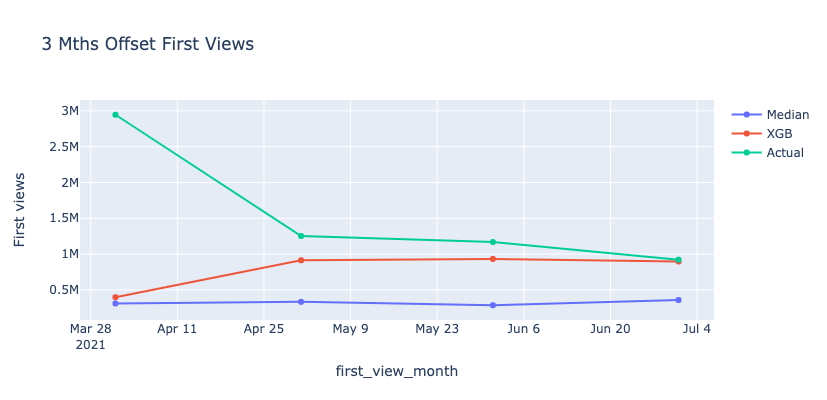

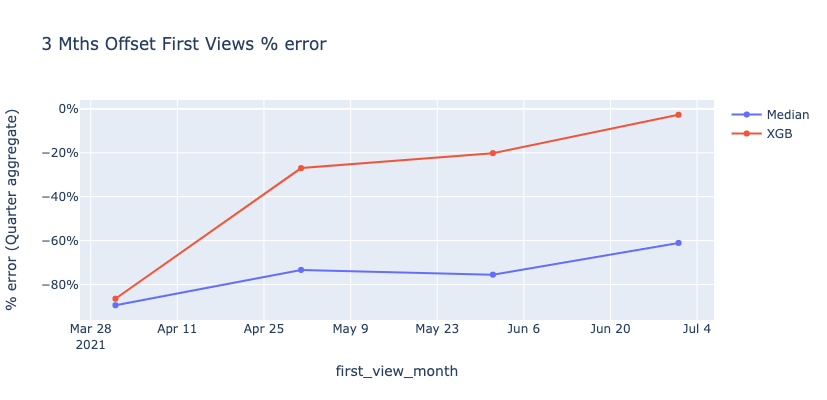

In [36]:
offset = 3

### Plot error 
## Month 
list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval_iii, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
display(df_grp)
get_pred_plot(df_grp, agg_var,'3 Mths Offset First Views')
get_pct_error_plot(df_grp, agg_var, '3 Mths Offset First Views % error')


# ## Popcorn 
# df_grp=evaluate_pred_plt(df_eval[df_eval.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
# get_pred_plot(df_grp, agg_var,'Popcorn First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp, agg_var, 'Popcorn First views prediction error (2021 Monthly Agg)')


# # ## Tiers 
# grpby=[agg_var,'tier', 'title_name', 'season_number'] 
# df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])

# get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')




,first_view_month,mae_first_views_decay_median_mx,mae_first_views_decay_dev_b,first_views,first_views_decay_median_mx,first_views_decay_dev_b,pct_error_first_views_decay_median_mx,pct_error_first_views_decay_dev_b
1,2021-04-01,60333.386364,64507.687730,2936513,395630.0,3.905674e+05,-86.527218,-86.699618
2,2021-05-01,25026.522727,30584.107522,1245353,356746.0,1.736009e+06,-71.353825,39.398985
3,2021-06-01,27515.857143,18655.030880,1148989,337583.0,1.337587e+06,-70.619127,16.414253
4,2021-07-01,12223.977273,11086.381832,900975,583332.0,7.022893e+05,-35.255473,-22.052295


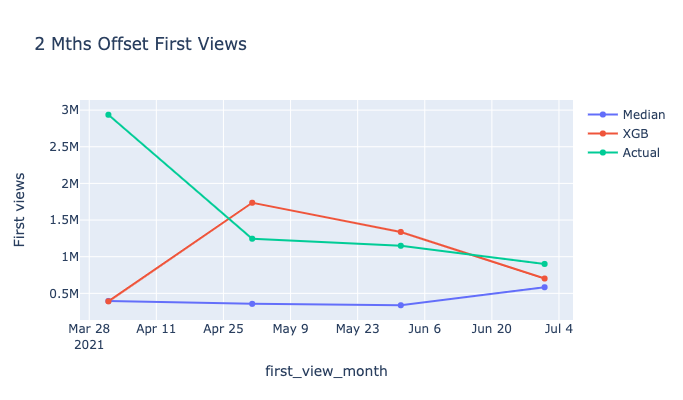

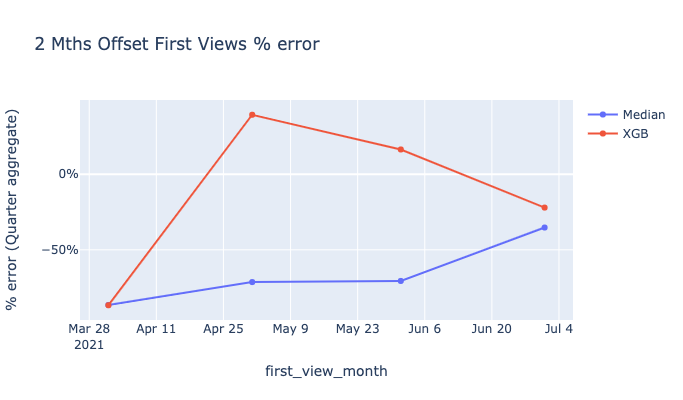

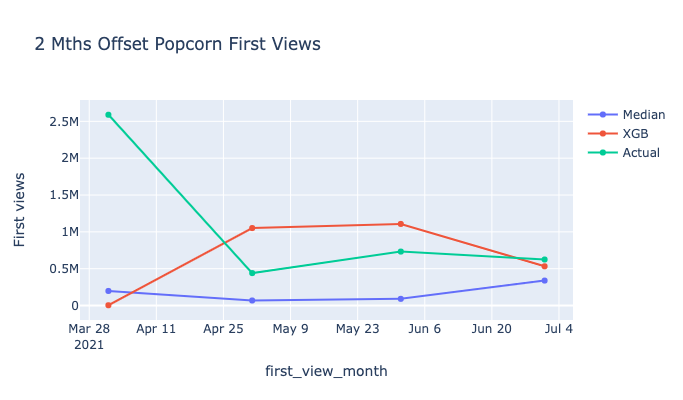

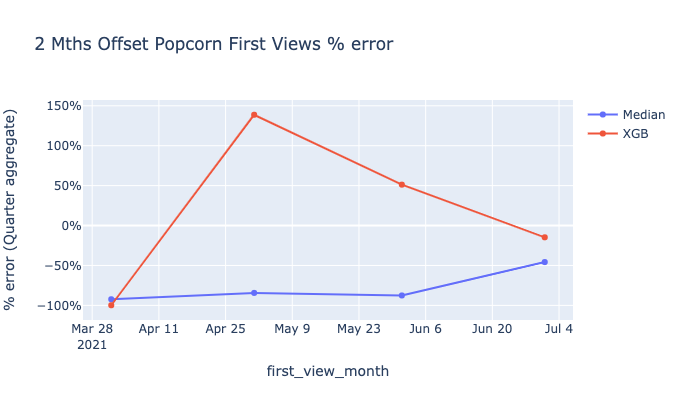

In [43]:
offset = 2

### Plot error 
## Month 
list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval_ii, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
display(df_grp)
get_pred_plot(df_grp, agg_var,'2 Mths Offset First Views')
get_pct_error_plot(df_grp, agg_var, '2 Mths Offset First Views % error')


## Popcorn 
df_grp=evaluate_pred_plt(df_eval_ii[df_eval_ii.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
get_pred_plot(df_grp, agg_var,'2 Mths Offset Popcorn First Views')
get_pct_error_plot(df_grp, agg_var, '2 Mths Offset Popcorn First Views % error')



# ## Tiers 
# grpby=[agg_var,'tier', 'title_name', 'season_number'] 
# df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])

# get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')




,first_view_month,mae_first_views_decay_median_mx,mae_first_views_decay_dev_b,first_views,first_views_decay_median_mx,first_views_decay_dev_b,pct_error_first_views_decay_median_mx,pct_error_first_views_decay_dev_b
2,2021-04-01,85251.483871,43487.937285,2916750,399480.0,4.095843e+06,-86.303934,40.424882
3,2021-05-01,35572.310345,38987.005630,1181063,360946.0,1.043980e+06,-69.438887,-11.606732
4,2021-06-01,40273.333333,28188.318487,1063773,309045.0,1.051940e+06,-70.948219,-1.112391
5,2021-07-01,12027.000000,32454.220624,829679,571244.0,1.641446e+06,-31.148794,97.841036


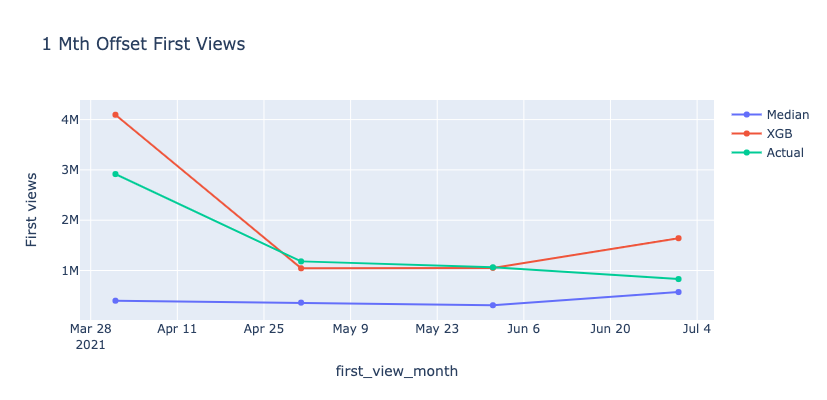

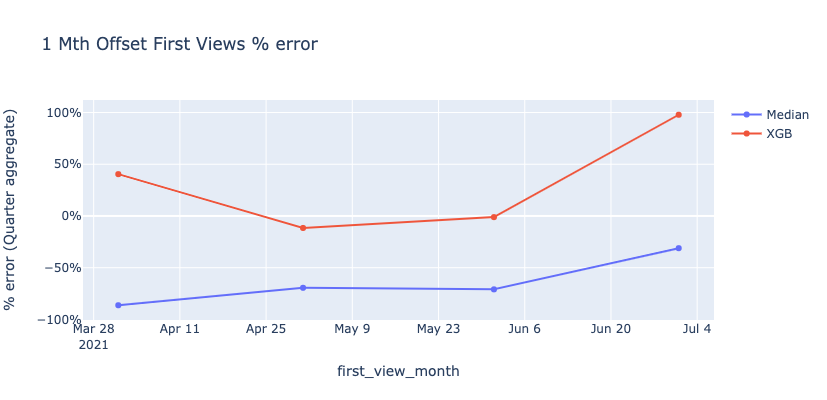

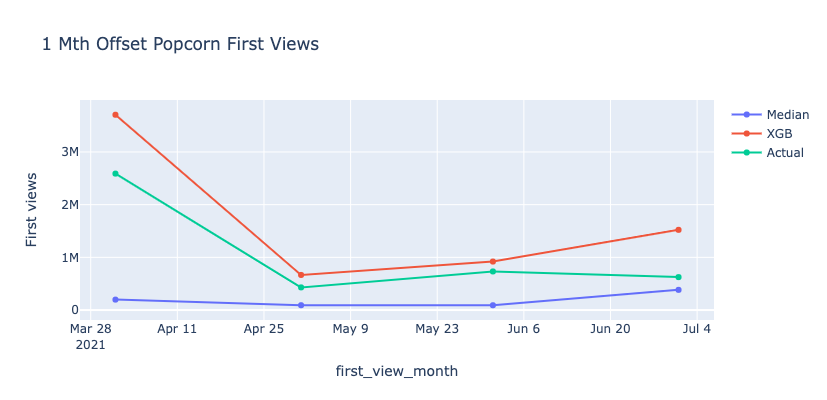

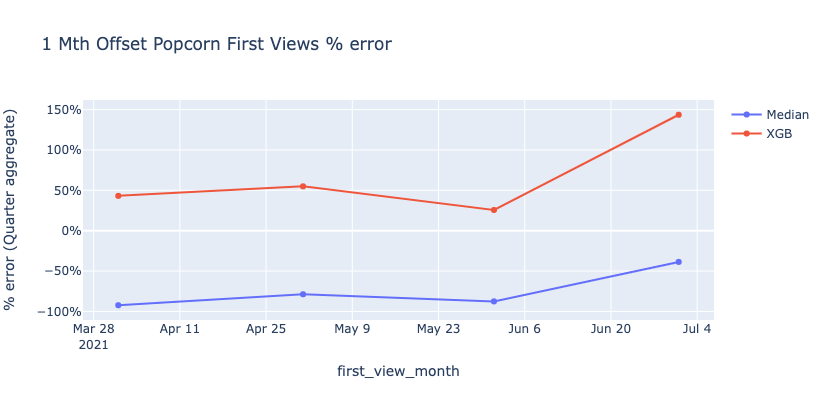

In [38]:
offset = 1

### Plot error 
## Month 
list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval_i, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
display(df_grp)
get_pred_plot(df_grp, agg_var,'1 Mth Offset First Views')
get_pct_error_plot(df_grp, agg_var, '1 Mth Offset First Views % error')


## Popcorn 
df_grp=evaluate_pred_plt(df_eval_i[df_eval_i.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
get_pred_plot(df_grp, agg_var,'1 Mth Offset Popcorn First Views')
get_pct_error_plot(df_grp, agg_var, '1 Mth Offset Popcorn First Views % error')



# ## Tiers 
# grpby=[agg_var,'tier', 'title_name', 'season_number'] 
# df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])

# get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')




,first_view_month,mae_first_views_decay_median_mx,mae_first_views_decay_dev_b,first_views,first_views_decay_median_mx,first_views_decay_dev_b,pct_error_first_views_decay_median_mx,pct_error_first_views_decay_dev_b
3,2021-04-01,48771.000000,29725.926100,858667,193287.0,479333.256785,-77.489877,-44.177049
4,2021-05-01,54437.000000,63231.295108,743691,150652.0,458448.069810,-79.742662,-38.355033
5,2021-06-01,47833.692308,23838.935824,715980,119870.0,895496.717082,-83.257912,25.072868
6,2021-07-01,16398.000000,22909.613191,750586,550874.0,994473.374871,-26.607477,32.492929


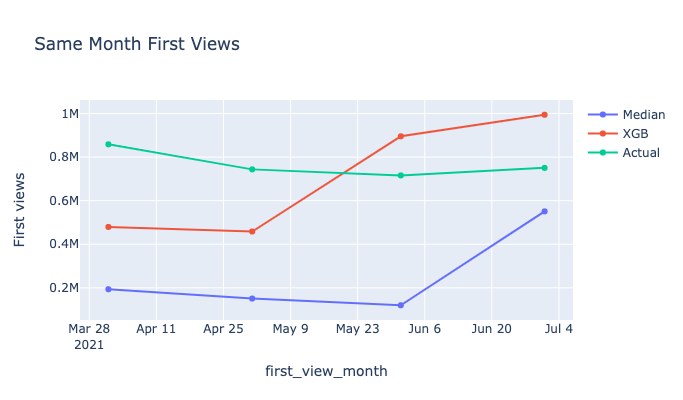

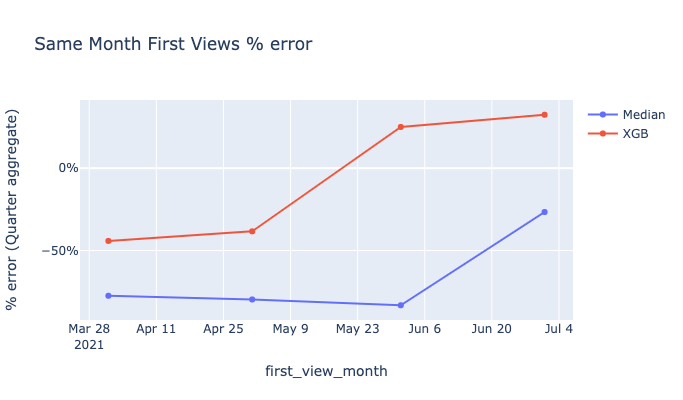

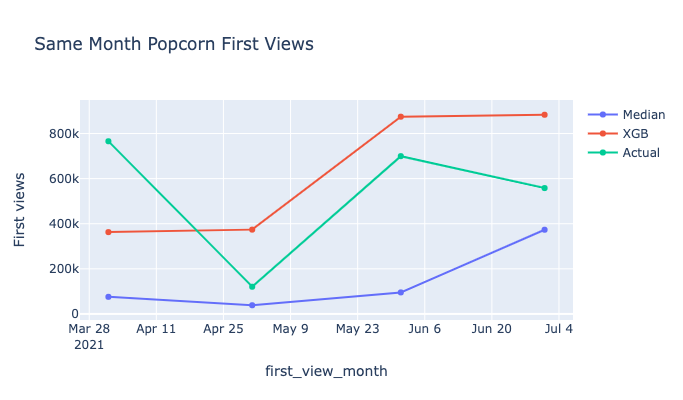

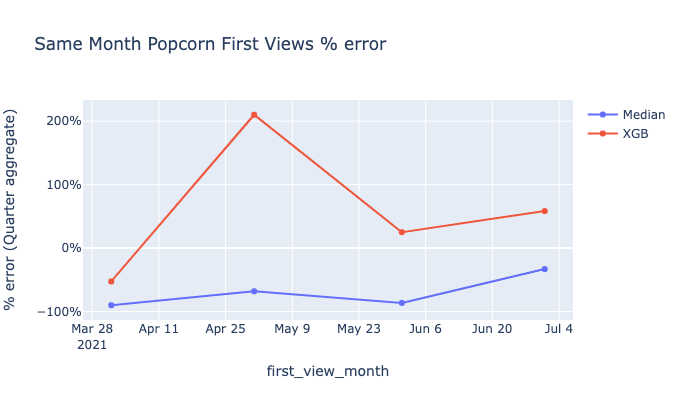

In [44]:
offset = 0

### Plot error 
## Month 
list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval_, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
display(df_grp)
get_pred_plot(df_grp, agg_var,'Same Month First Views')
get_pct_error_plot(df_grp, agg_var, 'Same Month First Views % error')


## Popcorn 
df_grp=evaluate_pred_plt(df_eval_[df_eval_.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
df_grp = df_grp[(df_grp.first_view_month>='2021-04-01') & (df_grp.first_view_month<='2021-07-01')]
get_pred_plot(df_grp, agg_var,'Same Month Popcorn First Views')
get_pct_error_plot(df_grp, agg_var, 'Same Month Popcorn First Views % error')


# ## Tiers 
# grpby=[agg_var,'tier', 'title_name', 'season_number'] 
# df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])

# get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')

# get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 First views (2021 Monthly Agg)')
# get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')




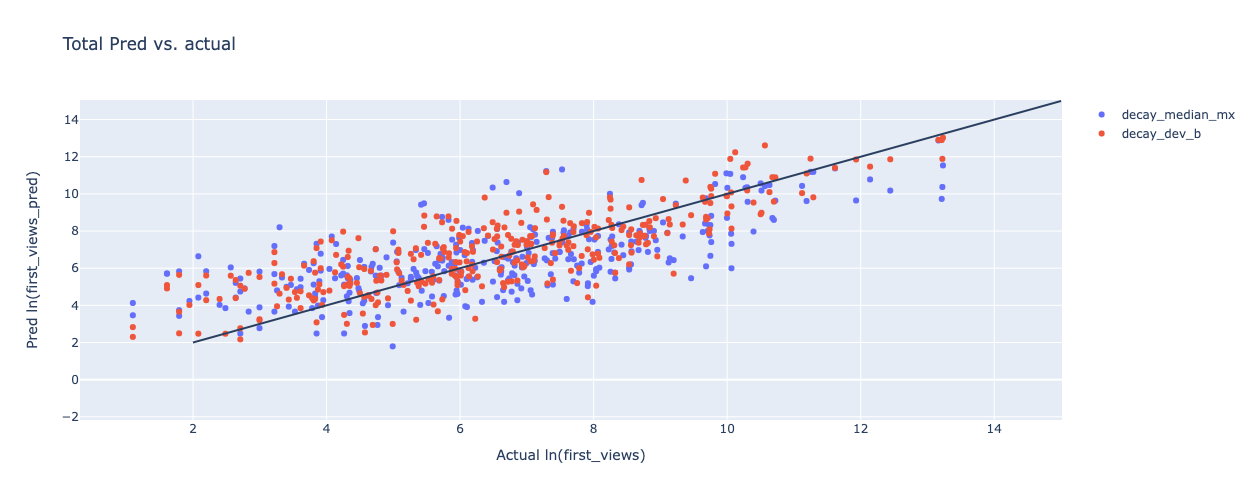

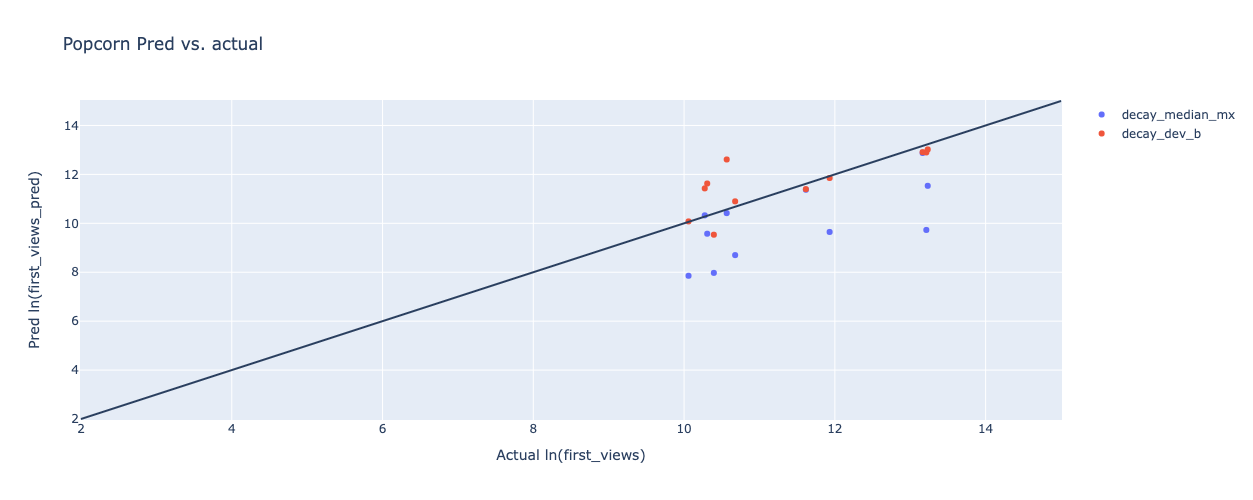

In [42]:
def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i in ['decay_median_mx'] + list_postfix:
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=i,
                    text= df_plt['effective_start_date'].astype(str) + " " + df_plt['title_name'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=700,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return fig

import plotly.io as pio
list_postfix = ['decay_dev_b']
fig = get_pred_actual_plot(df_eval, 'Total', list_postfix)
# pio.write_json(fig, 'total.json')

fig =get_pred_actual_plot(df_eval[df_eval.category=='Popcorn'], 'Popcorn', list_postfix)
# fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==1)], 'Q1', list_postfix)
# fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==2)], 'Q2', list_postfix)
# fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==3)], 'Q3', list_postfix)


# get_pred_actual_plot(df_eval[(df_eval.start_quarter==2)], 'Q2', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==1)], 'Q1 Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==2)], 'Q2 Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==1)], 'Q1 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==2)], 'Q2 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==1], 'Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==2], 'Tier 2', list_postfix)


In [ ]:
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_dev_log'] = np.log(df_eval['first_views_dev'])
# df_eval['first_views_median_log'] = np.log(df_eval['first_views_median'])
df_eval['first_views_median_mx_log'] = np.log(df_eval['first_views_median_mx'])
df_eval['first_views_dev_a_log'] = np.log(df_eval['first_views_dev_a'])
df_eval['first_views_dev_b_log'] = np.log(df_eval['first_views_dev_b'])
df_eval['first_views_dev_c_log'] = np.log(df_eval['first_views_dev_c'])


def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i in ['median_mx'] + list_postfix:
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=i,
                    text=df_plt['start_year_month'] + " " + df_plt['title_name'].astype(str) + df_plt['start_year_month'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=500,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return 

get_pred_actual_plot(df_eval, 'Total', list_postfix)
get_pred_actual_plot(df_eval[df_eval.category=='Popcorn'], 'Popcorn', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.start_quarter==1)], 'Q1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.start_quarter==2)], 'Q2', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==1)], 'Q1 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==2)], 'Q2 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==1)], 'Q1 Tier 2', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==2)], 'Q2 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==1], 'Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==2], 'Tier 2', list_postfix)


In [15]:
df_test[df_test.title_name.str.contains('Godzilla')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,start_year,start_month,start_year_month,start_quarter,first_views,premiering_hours_runtime,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
0,1,movies,Pay1,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-08-17,2021,8,2021-08,3,68095,0.0,11.128659,Godzilla vs. Kong,tt5034838,"[""Action"",""Sci-Fi"",""Thriller""]",movie,3.0,2.0,0.0,0.0,146.0,18.0,5.0,164.0


## Model diagnosis

2021-03-01 122 (1, 27)


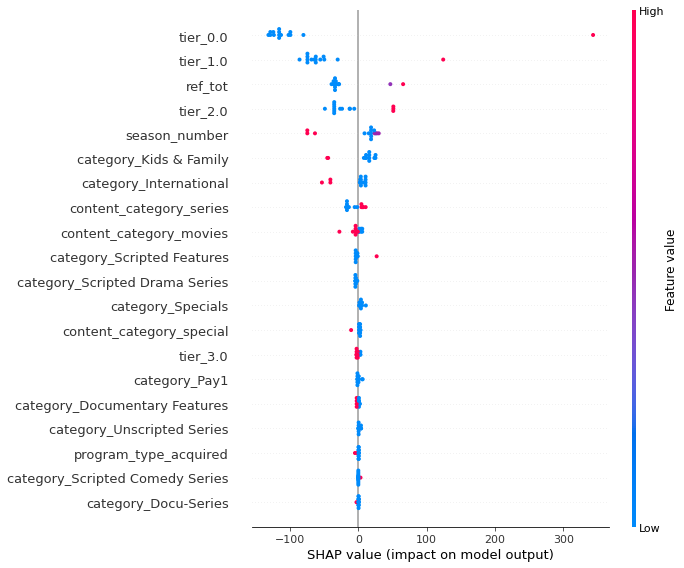

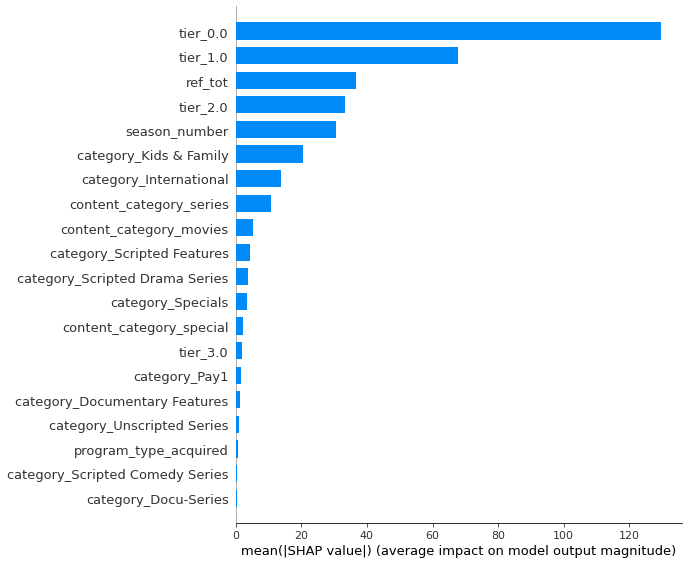

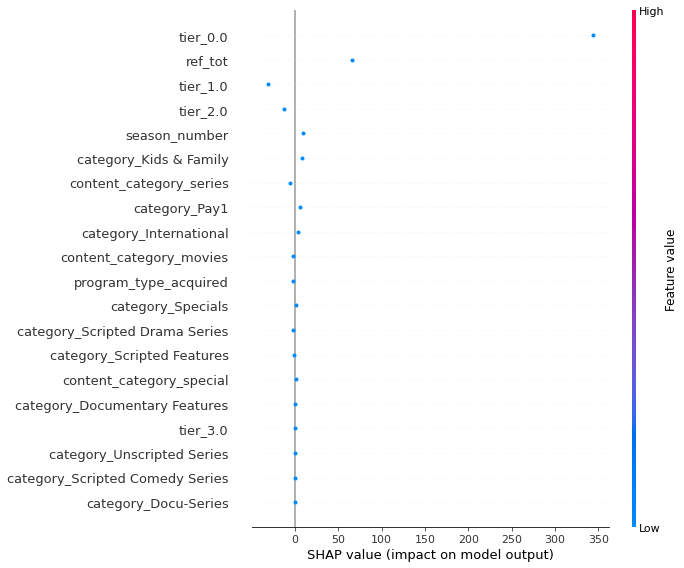

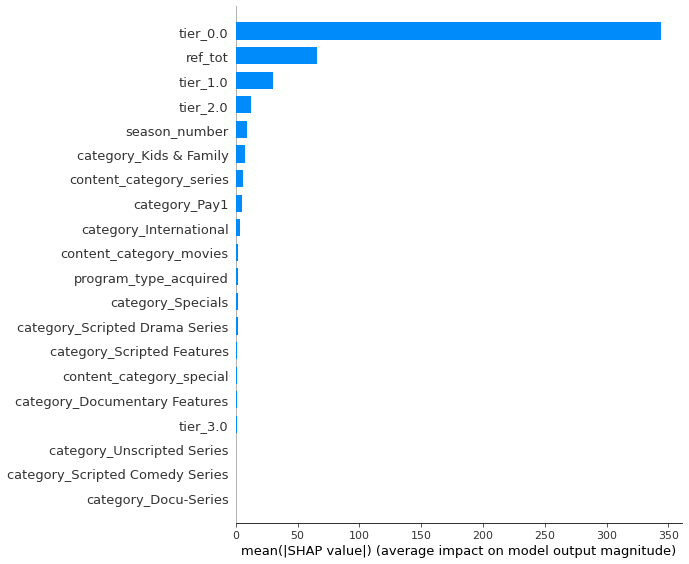

In [82]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
]


df_pred_list = []
for title, date_pred in zip(['Godzilla'],['2021-03-01']):
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
#     df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
#     df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

    ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)
    ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains(title)], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)

2021-04-01 135 (2, 27)


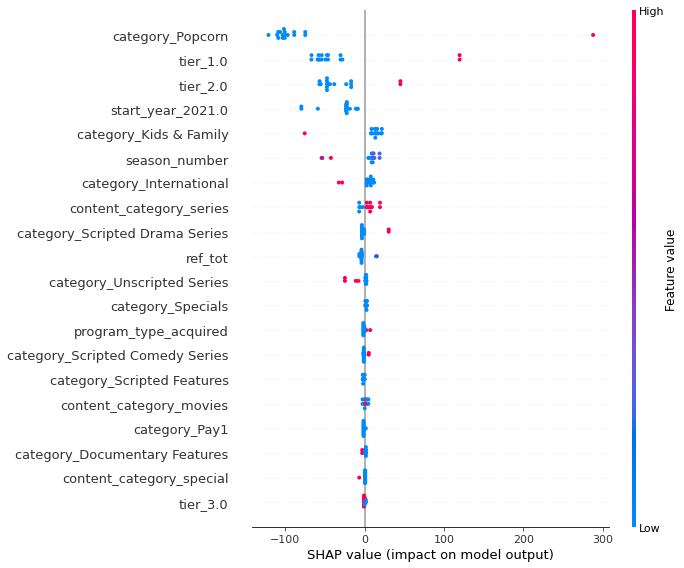

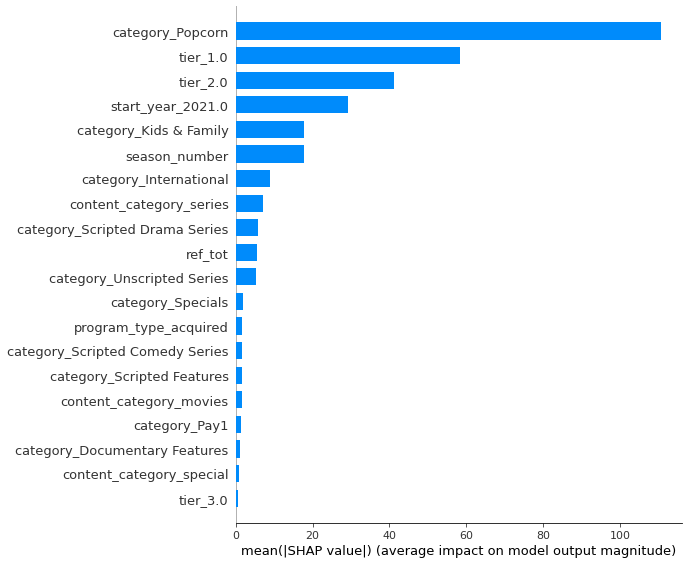

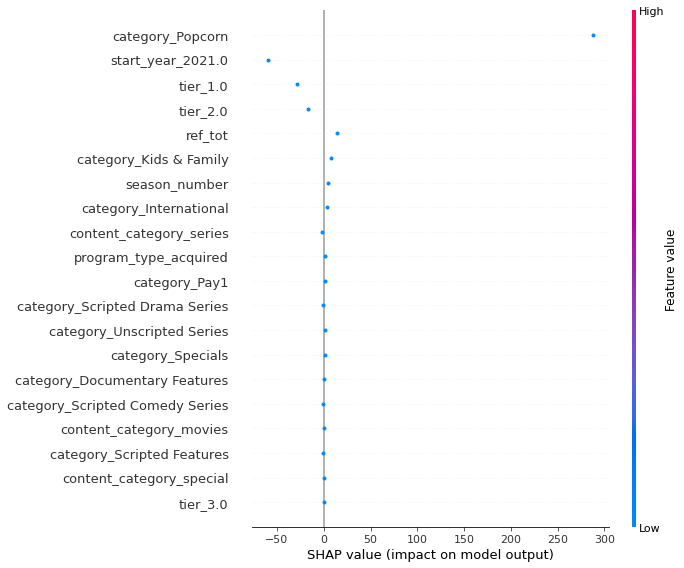

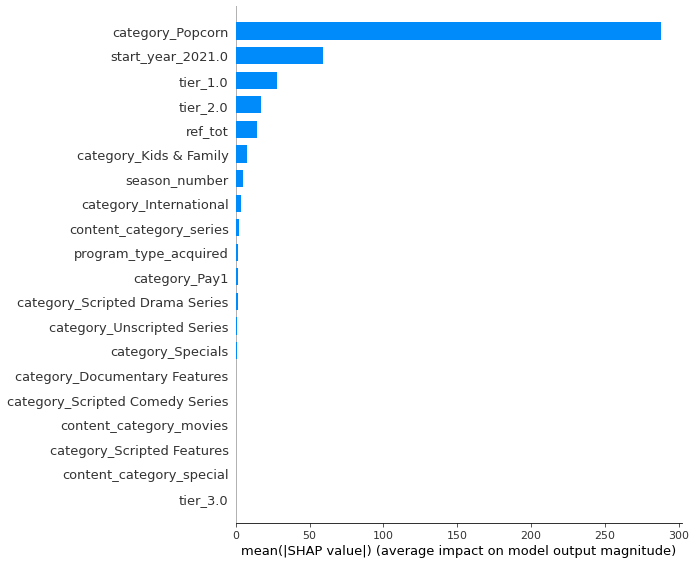

In [68]:
df_pred_list = []
for title, date_pred in zip(['Mortal'],['2021-04-01']):
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
#     df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
#     df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

    ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)
    ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains(title)], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)
# display(df_pred)